# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Тестовое задание СберМаркет</center>
***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Обзор</center>
<p style="font-family: consolas; font-size: 16px;">⚪ Целью данной задачи является предсказание следующего заказа пользователя</p>
<p style="font-family: consolas; font-size: 16px;">⚪ Заказ пользователя представляет собой набор из одной или нескольких уникальных категорий товаров</p>
<p style="font-family: consolas; font-size: 16px;">⚪ В качестве тренировочных данных используется датасет историй заказов 20000 пользователей до даты отсечки</p>
<p style="font-family: consolas; font-size: 16px;">⚪ Столбцы train.csv:</p>

*   <p style="font-family: consolas; font-size: 14px;">    <b>user_id</b> - уникальный id пользователя</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>order_completed_at</b> - дата заказа</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>cart</b> - список уникальных категорий, из которых состоял заказ</p>

<p style="font-family: consolas; font-size: 16px;">⚪ В качестве прогноза для каждой пары пользователь-категория вернуть значение 0 или 1</p>
<p style="font-family: consolas; font-size: 16px;">⚪ В качеcтве матрики используется F1</p>

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Содержание</center>
* [0. Загрузка данных и извлечение признаков](#0)
* [1. EDA](#1)
    * [1.1 Анализ train.csv](#1.1)
    * [1.2 Анализ sample_submission.csv](#1.2)
* [2. Создание тренировочного набора](#2)
* [3. Обучение модели, постобработра и предсказание](#3)
* [4. Идеи, которые не улучшили решение](#4)

<a id="0"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 0. Загрузка данных и извлечение признаков </b></div>

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [46]:
data = pd.read_csv('/kaggle/input/sbermarket-internship-competition/train.csv')
sample_submission = pd.read_csv('/kaggle/input/sbermarket-internship-competition/sample_submission.csv')

<p style="font-family: consolas; font-size: 18px;">Добавленные столбцы:</p>

*   <p style="font-family: consolas; font-size: 14px;">    <b>user_cart_number</b> - номер заказа пользователя</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>cart_num_among_all_users</b> - номер заказа среди всех заказов</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>is_last_cart</b> - является ли заказ последним у пользователя</p>

In [47]:
#добавление столбца  user_purchase_number

current_num_user_last_cart = np.zeros(len(data['user_id'].unique()), dtype=np.int64)
current_num_user_last_cart[2] = 1
user_cart_number = np.ones(len(data), dtype=np.int64)
id_pred, date_pred = data['user_id'][0], data['order_completed_at'][0] 

for i in tqdm(range(len(data))):        

    if id_pred != data['user_id'][i]:
        current_num_user_last_cart[data['user_id'][i]] += 1    
    
    elif date_pred != data['order_completed_at'][i]:
        current_num_user_last_cart[id_pred] += 1
    
    user_cart_number[i] = current_num_user_last_cart[data['user_id'][i]]
    id_pred = data['user_id'][i]
    date_pred = data['order_completed_at'][i]    
    
data['user_cart_number'] = user_cart_number


#добавление столбца  purch_num_among_all_users

mask = pd.to_datetime(data['order_completed_at']).diff().astype(np.int64).ne(0)
data['cart_num_among_all_users'] = np.nan
data.loc[mask, 'cart_num_among_all_users'] = np.arange(1, mask.sum() + 1)
data['cart_num_among_all_users'] = data['cart_num_among_all_users'].fillna(method='ffill').astype(np.int64)


#добавление столбца is_last_purch

users_last_cart_num = data.groupby("user_id")[['user_cart_number']].max().reset_index()
users_last_cart_num['is_last_cart'] = np.ones(len(users_last_cart_num))

data = pd.merge(data, users_last_cart_num, on=['user_id', 'user_cart_number'], how="left").fillna(0)
data['is_last_cart'] = data['is_last_cart'].astype(np.int64)


data.head(5)

100%|██████████| 3123064/3123064 [02:38<00:00, 19670.74it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


,user_id,order_completed_at,cart,user_cart_number,cart_num_among_all_users,is_last_cart
0,2,2015-03-22 09:25:46,399,1,1,0
1,2,2015-03-22 09:25:46,14,1,1,0
2,2,2015-03-22 09:25:46,198,1,1,0
3,2,2015-03-22 09:25:46,88,1,1,0
4,2,2015-03-22 09:25:46,157,1,1,0


<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. EDA </b></div>

<a id="1.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> 1.1 Анализ train.csv</div>

In [49]:
print('Объем датасета: ', len(data))
print('Количество уникальных пользователей: ', len(data['user_id'].unique()))
print('Количество уникальных категорий: ', len(data['cart'].unique()))
print('Количество заказов: ', len(data['order_completed_at'].unique()))

Объем датасета:  3123064
Количество уникальных пользователей:  20000
Количество уникальных категорий:  881
Количество заказов:  208155


<AxesSubplot:xlabel='cart', ylabel='count'>

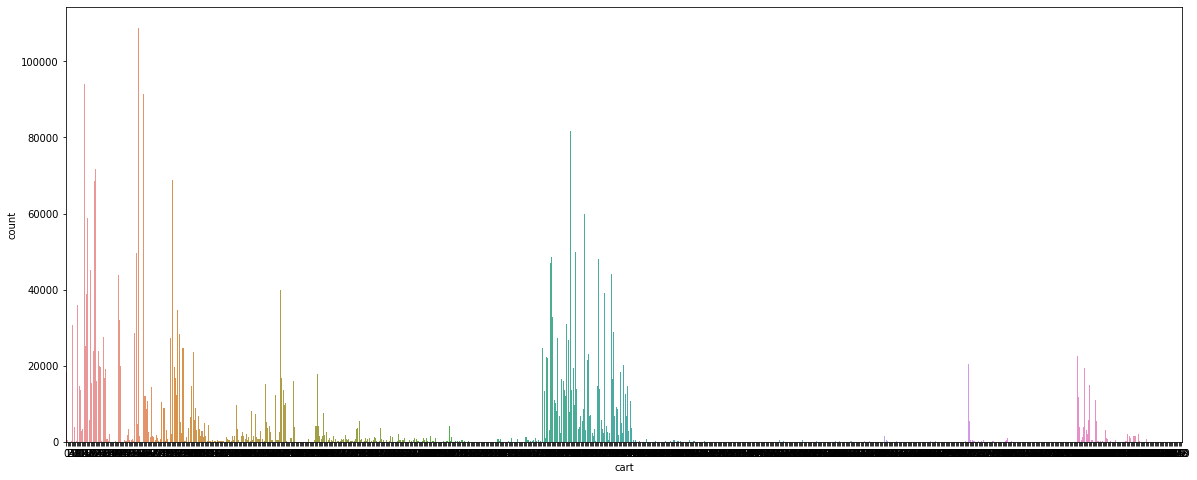

In [82]:
fig = plt.figure(figsize=(20, 8))
sns.countplot(data['cart'])

In [89]:
data.groupby(by='cart')['cart'].count().describe()

count       881.000000
mean       3544.908059
std       10686.317664
min           1.000000
25%           7.000000
50%          66.000000
75%        1101.000000
max      108877.000000
Name: cart, dtype: float64

<a id="1.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> 1.2 Анализ sample_submission.csv</div>

In [96]:
temp = sample_submission

user_ids = np.zeros(len(temp), dtype=np.int64)
carts = np.zeros(len(temp), dtype=np.int64)

for i in range(len(temp)):
    user_ids[i], carts[i] = temp['id'][i].split(sep=';')[0], temp['id'][i].split(sep=';')[1]

temp['user_id'] = user_ids
temp['cart'] = carts

print('Объем: ', len(temp))
print('Количество уникальных пользователей: ', len(temp['user_id'].unique()))
print('Количество уникальных категорий: ', len(temp['cart'].unique()))

Объем:  790449
Количество уникальных пользователей:  13036
Количество уникальных категорий:  858


<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. Создание тренировочного набора </b></div>

<p style="font-family: consolas; font-size: 18px;">Признаки:</p>

*   <p style="font-family: consolas; font-size: 14px;">    <b>user_last_cart_num</b> - номер последнего заказа пользователя</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>last_num_users_cart_cont_cat</b> - номер последнего заказа пользователя содержащего эту категорию, поделенный на номер последнего заказа</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>share_cart_cont_cat	</b> - доля заказов пользователя, содержащих эту категорию</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>share_all_carts_cont_cat</b> - доля всех заказов, содержащих эту категорию</p>
*   <p style="font-family: consolas; font-size: 14px;">    <b>average_norm_num_last_cart_cont_cat</b> - среднее значение last_num_users_cart_cont_cat категории по всем пользователям</p>


In [24]:
def create_featrues(df):
    
    X = sample_submission
    
    user_ids = np.zeros(len(X), dtype=np.int64)
    carts = np.zeros(len(X), dtype=np.int64)

    for i in tqdm(range(len(X))):
        user_ids[i], carts[i] = X['id'][i].split(sep=';')[0], X['id'][i].split(sep=';')[1]

    X['user_id'] = user_ids
    X['cart'] = carts
    X = X.drop(['target', 'id'], axis=1)
    
    user_last_cart_num = df.groupby("user_id")[['user_cart_number']].max().reset_index()
    
    X = pd.merge(X, user_last_cart_num, on=['user_id'], how="left")
    X = pd.merge(X, df.groupby(['user_id', 'cart']).agg({'user_cart_number': ['count']}).reset_index().droplevel(1, axis=1) , on=['user_id', 'cart'], how="left")
    X = pd.merge(X, df.groupby(['user_id', 'cart']).agg({'user_cart_number': ['max']}).reset_index().droplevel(1, axis=1) , on=['user_id', 'cart'], how="left")
        
        
    temp = df.groupby(by='cart')[['cart_num_among_all_users']].count().reset_index() 
    temp['cart_num_among_all_users'] = temp['cart_num_among_all_users'] / temp['cart_num_among_all_users'].sum()
    
    X = pd.merge(X, temp, on='cart', how="left")
    
    X.columns = ['user_id', 'cart', 'user_last_cart_num', 'last_num_users_cart_cont_cat', 'count_user_carts_cont_cat', 'share_all_carts_cont_cat']

    X = X.fillna(0)
    
    X['last_num_users_cart_cont_cat'] = X['last_num_users_cart_cont_cat'] / X['user_last_cart_num']
    X['count_user_carts_cont_cat'] = X['count_user_carts_cont_cat'] / X['user_last_cart_num']
#count_user_carts_cont_cat
    
    X = pd.merge(X, X.groupby(by='cart')[['last_num_users_cart_cont_cat']].mean().reset_index(), on='cart', how="left")

    X.columns = ['user_id', 'cart', 'user_last_cart_num', 'last_num_users_cart_cont_cat', 'share_cart_cont_cat', 'share_all_carts_cont_cat', 
                 'average_norm_num_last_cart_cont_cat']
    
    return X
    

In [40]:
X_train = create_featrues(data[data['is_last_cart'] == 0])
X_train.head(5)

100%|██████████| 790449/790449 [00:17<00:00, 46001.47it/s]


,user_id,cart,user_last_cart_num,last_num_users_cart_cont_cat,share_cart_cont_cat,share_all_carts_cont_cat,average_norm_num_last_cart_cont_cat
0,0,133,2,0.5,1.0,0.000467,0.130252
1,0,5,2,0.5,1.0,0.009782,0.228316
2,0,10,2,0.5,1.0,0.004683,0.219201
3,0,396,2,0.5,1.0,0.008578,0.244851
4,0,14,2,1.0,1.0,0.029963,0.512749


In [41]:
y_train = pd.merge(X_train, data[data['is_last_cart'] == 1][['user_id', 'cart', 'is_last_cart']], on=['user_id', 'cart'], how="left")['is_last_cart'].fillna(0).astype(np.int64)
X_train = X_train.drop(['user_id', 'cart'], axis=1)

X_test = create_featrues(data)
X_test = X_test.drop(['user_id', 'cart'], axis=1)

0.23266902735027814

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3. Обучение модели, постобработра и предсказание </b></div>

In [42]:
param = {'n_estimators': 1100, 'max_depth': 14, 'learning_rate': 0.12056807264550261}
model = lgb.LGBMClassifier(**param)
model.fit(X_train, y_train)

preds_proba = model.predict_proba(X_test)
predict = (preds_proba[:,1] > 0.25) * 1

LGBMClassifier(learning_rate=0.12056807264550261, max_depth=14,
               n_estimators=1100)

In [108]:
print(f'Доля покупок в тренировочном наборе:  {y.mean()}')
print(f'Доля покупок в предсказании с порогом 0.5:  {((preds_proba[:,1] > 0.5) * 1).mean()}')
print(f'Доля покупок в предсказании с порогом 0.25:  {((preds_proba[:,1] > 0.25) * 1).mean()}')

Доля покупок в тренировочном наборе:  0.23266902735027814
Доля покупок в предсказании с порогом 0.5:  0.06742370475514549
Доля покупок в предсказании с порогом 0.25:  0.23714116913298644


In [108]:
sample_submission['target'] = predict
sample_submission = sample_submission.drop(['user_id', 'cart'], axis=1)
sample_submission.to_csv('submission.csv', index=False)

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4. Идеи, которые не улучшили решение </b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Кластеризация пользователей по категориям</p>
<p style="font-family: consolas; font-size: 16px;">⚪ Кластеризация категорий по пользователям</p>
<p style="font-family: consolas; font-size: 16px;">⚪ Использование выхода с LightFM в качестве признака</p>